In [1]:
from __future__ import division
%matplotlib inline
import GPy
import fipy  
from sklearn import metrics
import seaborn as sns
sns.set()
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
import random 
os.environ['PYTHONHASHSEED'] = '0'

seed = 1
# Setting the seed for numpy-generated random numbers
np.random.seed(seed=seed)

# Setting the seed for python random numbers
random.seed(seed)

# Setting the graph-level random seed.
tf.set_random_seed(seed)

 /Users/sharmila/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


In [2]:
path='/Users/sharmila/Desktop/research/work/03_NN_PDE/Level3/part8_image/2_2dim_c=0_f=0_boundedfield/data'

In [3]:
cellcenters = np.load(os.path.join(path,'cellcenters_nx1=32_nx2=32.npy')) # or x_fipy
nx1 = int(np.sqrt(cellcenters.shape[0]))
nx2 = int(np.sqrt(cellcenters.shape[0]))

#generating a grid 
X1 = cellcenters[:,0].reshape(nx1,nx2)
X2 = cellcenters[:,1].reshape(nx1,nx2)

print X1
print X1.shape
print X2
print X2.shape

[[0.015625 0.046875 0.078125 ... 0.921875 0.953125 0.984375]
 [0.015625 0.046875 0.078125 ... 0.921875 0.953125 0.984375]
 [0.015625 0.046875 0.078125 ... 0.921875 0.953125 0.984375]
 ...
 [0.015625 0.046875 0.078125 ... 0.921875 0.953125 0.984375]
 [0.015625 0.046875 0.078125 ... 0.921875 0.953125 0.984375]
 [0.015625 0.046875 0.078125 ... 0.921875 0.953125 0.984375]]
(32, 32)
[[0.015625 0.015625 0.015625 ... 0.015625 0.015625 0.015625]
 [0.046875 0.046875 0.046875 ... 0.046875 0.046875 0.046875]
 [0.078125 0.078125 0.078125 ... 0.078125 0.078125 0.078125]
 ...
 [0.921875 0.921875 0.921875 ... 0.921875 0.921875 0.921875]
 [0.953125 0.953125 0.953125 ... 0.953125 0.953125 0.953125]
 [0.984375 0.984375 0.984375 ... 0.984375 0.984375 0.984375]]
(32, 32)


## 2 layer stratification

In [4]:
variance = 0.75
x1 = X1[0,:]
def samplestratefied(nsamples = 1):
    lowerl= np.zeros((nsamples, 2))
    upperl = np.zeros((nsamples, 2))
    samples = np.zeros((nsamples, nx1*nx2))
    for i in xrange(nsamples):
        lx1_lower = np.random.uniform(low=0.035, high=1.) # h = 1/32 = 0.035
        lx2_lower = np.random.uniform(low=0.035, high=1.)
        lowerl[i] = np.array([lx1_lower, lx2_lower])
        lx1_upper = np.random.uniform(low=0.035, high=1.)
        lx2_upper = np.random.uniform(low=0.035, high=1.)
        upperl[i] = np.array([lx1_upper, lx2_upper])
        k1 = GPy.kern.Exponential(2, lengthscale=[lx1_lower, lx2_lower],variance = variance, ARD=True)
        k2 = GPy.kern.Exponential(2, lengthscale=[lx1_upper, lx2_upper],variance = variance, ARD=True)
        a = np.random.uniform(0, 1)
        b = np.random.uniform(0, 1)
        y = a + (b-a)*x1 #line
        x1lower = X1[np.where(X2 < y)][:, None]
        x2lower = X2[np.where(X2 < y)][:, None]
        x1upper = X1[np.where(X2 >= y)][:, None]
        x2upper = X2[np.where(X2 >= y)][:, None]
        lower_X = np.hstack([x1lower, x2lower])
        upper_X = np.hstack([x1upper, x2upper])
        K1 = k1.K(lower_X)
        K2 = k2.K(upper_X)
        L1 = np.linalg.cholesky(K1 + 1e-6*np.eye(K1.shape[0]))
        L2 = np.linalg.cholesky(K2 + 1e-6*np.eye(K2.shape[0]))
    
        z1 = np.random.randn(lower_X.shape[0], 1)
        z2 = np.random.randn(upper_X.shape[0], 1)
        sample = np.zeros((32, 32))
        sample[np.where(X2 < y)] = np.dot(L1, z1)[:, 0]
        sample[np.where(X2 >= y)] = np.dot(L2, z2)[:, 0]
        
#         print sample
        samples[i] = np.exp(sample.flatten())
    return samples, lowerl, upperl  

In [5]:
nsamples = 1000
samples, lowerl, upperl = samplestratefied(nsamples=nsamples)

In [6]:
print (samples)
print type(samples)
print samples.shape

[[ 0.6329205   0.46536394  0.64486249 ...  0.57513633  0.86551665
   1.46745601]
 [ 1.3990428   1.2585766   1.68365472 ...  2.47520918  1.78957669
   1.35832061]
 [ 0.24760811  0.37014281  0.57175531 ...  1.74252899  1.41486992
   1.56201743]
 ...
 [ 6.4092766   6.82052463  5.10730193 ...  2.18898203  2.30851696
   2.36318057]
 [10.00168189  5.86650005  3.92456369 ...  0.46316305  0.46589233
   0.56440739]
 [ 0.13950529  0.16104179  0.18234442 ...  0.23978835  0.28908081
   0.25278287]]
<type 'numpy.ndarray'>
(1000, 1024)


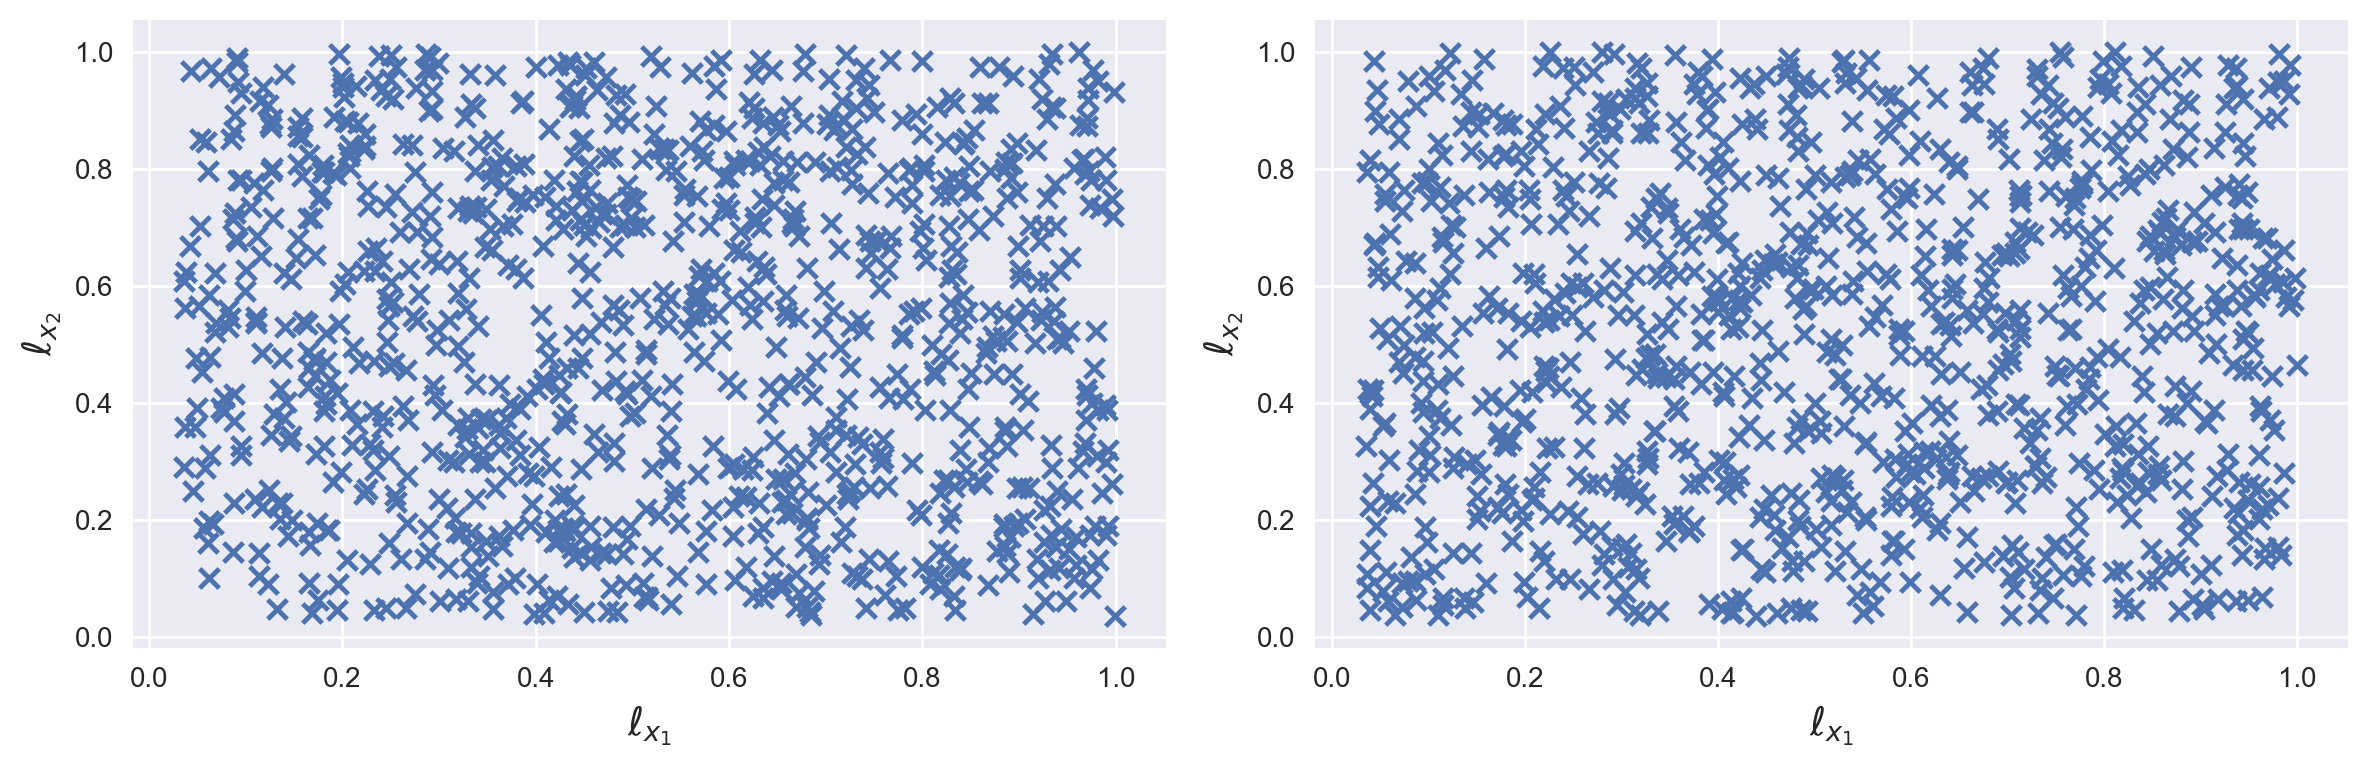

In [7]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ax[0].scatter(lowerl[:, 0], lowerl[:, 1], marker='x')
ax[1].scatter(upperl[:, 0], upperl[:, 1], marker='x')
ax[0].set_xlabel('$\ell_{x_1}$', fontsize = 14)
ax[0].set_ylabel('$\ell_{x_2}$', fontsize = 14)
ax[1].set_xlabel('$\ell_{x_1}$', fontsize = 14)
ax[1].set_ylabel('$\ell_{x_2}$', fontsize = 14)
plt.tight_layout()

In [8]:
#save data
datadir = os.getcwd()
datafile = "exp"+"_nx1="+str(nx1)+\
            "_nx2="+str(nx2)+\
            "_stratified"+\
            "_v="+str(variance)+\
            "_num_samples="+str(nsamples)+".npz"
np.savez(os.path.join(datadir, datafile), inputs=samples, lower=lowerl, upper=upperl)